In [1]:
import pandas as pd

In [2]:
path="C:/Users/Lina/OneDrive/Desktop/bgg-15m-reviews.csv"
df = pd.read_csv(path,index_col=0)

In [3]:
df.head()
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 15823269 entries, 0 to 15823268
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user     object 
 1   rating   float64
 2   comment  object 
 3   ID       int64  
 4   name     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 724.3+ MB


,user,rating,comment,ID,name
15823264,Fafhrd65,8.0,Turn based preview looks very promising. The g...,281515,Company of Heroes
15823265,PlatinumOh,8.0,KS,281515,Company of Heroes
15823266,BunkerBill,7.0,NaN,281515,Company of Heroes
15823267,Hattori Hanzo,6.0,NaN,281515,Company of Heroes
15823268,Richie2000,1.0,NaN,281515,Company of Heroes


In [4]:
df.isnull().sum()
# Count how many duplicate rows exist 
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:",num_duplicates)

Number of duplicate rows: 0


In [5]:
#EDA
columns_to_loop = ['user', 'name']
for col in columns_to_loop:
    value_counts = df[col].value_counts()
    print(f"Value counts for column '{col}':\n{value_counts}\n")


Value counts for column 'user':
user
leffe dubbel    6027
TomVasel        4950
Doel            4876
warta           4811
Hessu68         4602
                ... 
Cptkremmen         1
GaiaGirl           1
Slight_56          1
llewellynw         1
smedzz31           1
Name: count, Length: 351048, dtype: int64

Value counts for column 'name':
name
Pandemic                             96234
Carcassonne                          96221
Catan                                96185
7 Wonders                            79870
Dominion                             74954
                                     ...  
Top Ten: The Bill of Rights             30
Saga: The Crescent and The Cross        30
All Things Zombie: Final Fade Out       30
In Extremis                             30
Company of Heroes                       30
Name: count, Length: 18984, dtype: int64



In [6]:
# Count the number of unique games names in the 'game' column
num_unique_games = df['name'].nunique()
print(f"Number of unique games: {num_unique_games}")

# Count the number of unique games  in the 'game' column
num_unique_games_ID = df['ID'].nunique()

print(f"Number of unique games: {num_unique_games_ID}")


Number of unique games: 18984
Number of unique games: 19330


In [8]:
#DIFFRENT GAMES HAS SAME NAME

In [9]:
# Get unique values in the 'rating' column
unique_ratings = df['rating'].unique()
print("Unique ratings:", unique_ratings)


# Check if there are any ratings greater than 10
has_rating_above_10 = (df['rating'] > 10).any()
# Check if there are any ratings less than 0
has_rating_below_0 = (df['rating'] < 0).any()

# Print results
print("Is there any rating greater than 10? " + str(has_rating_above_10))
print("Is there any rating less than 0? " + str(has_rating_below_0))


Unique ratings: [10.       9.9      9.8     ...  2.34667  5.362    4.33375]
Is there any rating greater than 10? False
Is there any rating less than 0? False


In [10]:
# Drop the specified columns in place
df.drop(columns=['user', 'comment'], inplace=True)

# Display the DataFrame after dropping the columns
print(df.head()) 


   rating     ID      name
0    10.0  30549  Pandemic
1    10.0  30549  Pandemic
2    10.0  30549  Pandemic
3    10.0  30549  Pandemic
4    10.0  30549  Pandemic


In [11]:
#compute the rating of each game
# Calculate the average rating for each game and sort in descending order
average_ratings = df.groupby('name')['rating'].mean().sort_values(ascending=False)
# Display the average ratings
print(average_ratings)


name
Aeolis                                       9.687500
Dungeon Crusade: Book I – Genesis of Evil    9.565405
Thug Life the Game                           9.392857
TerroriXico                                  9.380282
Conqueror: Final Conquest                    9.360000
                                               ...   
Ms. Monopoly                                 1.466667
W.W.B                                        1.416667
Rock Paper Scissors Game                     1.320000
Alien: USCSS Nostromo                        1.231933
Oneupmanship: Mine's Bigger                  1.048437
Name: rating, Length: 18984, dtype: float64


In [12]:
number_of_ratings = df[df['name'] == "Aeolis"].shape[0]
print(f"The number of ratings for Aeolis is: {number_of_ratings}")


The number of ratings for Aeolis is: 32


In [13]:
import math

class Game:
    def __init__(self, game_id, name, average_rank=0, wilson_rank=0):
        self.id = game_id
        self.name = name
        self.average_rank = average_rank  
        self.wilson_rank = wilson_rank

    def calculate_average_rank(self, ratings):
        self.average_rank = sum(ratings) / len(ratings)  

    def calculate_wilson_rank(self, upvotes, total_votes, confidence=1.96):
            p_hat = upvotes / total_votes
            z = confidence
            denominator = 1 + z**2 / total_votes
            center_adjusted_probability = p_hat + z**2 / (2 * total_votes)
            adjustment = z * math.sqrt(
                (p_hat * (1 - p_hat) + z**2 / (4 * total_votes)) / total_votes
            )
            lower_bound = (center_adjusted_probability - adjustment) / denominator
            self.wilson_rank = lower_bound

    def get_average_rank(self):
        return self.average_rank
    def get_wilson_rank(self):
        return self.wilson_rank        


# Group data by ID and name and calculate average and Wilson rank
grouped = df.groupby(['ID', 'name']).agg(
    average_rating=('rating', 'mean'),
    total_votes=('rating', 'count')
).reset_index()

# Assume all ratings above 7.0 are positive votes
positive_threshold = 7.0
grouped['positive_votes'] = df[df['rating'] >= positive_threshold].groupby('ID')['rating'].count().reindex(grouped['ID']).fillna(0).values

# Create Game objects and calculate ranks
games = []
for _, row in grouped.iterrows():
    ratings = df[df['ID'] == row['ID']]['rating'].tolist()  
    game = Game(row['ID'], row['name'])
    game.calculate_average_rank(ratings) 
    game.calculate_wilson_rank(row['positive_votes'], row['total_votes'])  
    games.append(game)

# Sort games by average rank in descending order
sorted_games_average = sorted(games, key=lambda game: game.get_average_rank(), reverse=True)

# Sort games by wilson rank in descending order
sorted_games_wilson = sorted(games, key=lambda game: game.get_wilson_rank(), reverse=True)


In [14]:
# Print sorted game information by average rank
for game in sorted_games_average[:10]:
    print(f"Game ID: {game.id}, Name: {game.name}, Average Rank: {game.get_average_rank():.2f}, Wilson Rank: {game.wilson_rank:.4f}")

Game ID: 281257, Name: Aeolis, Average Rank: 9.69, Wilson Rank: 0.8928
Game ID: 147635, Name: Dungeon Crusade: Book I – Genesis of Evil, Average Rank: 9.57, Wilson Rank: 0.8230
Game ID: 211693, Name: Thug Life the Game, Average Rank: 9.39, Wilson Rank: 0.8421
Game ID: 228370, Name: TerroriXico, Average Rank: 9.38, Wilson Rank: 0.8276
Game ID: 294788, Name: Conqueror: Final Conquest, Average Rank: 9.36, Wilson Rank: 0.8547
Game ID: 85147, Name: Wings of the Motherland, Average Rank: 9.33, Wilson Rank: 0.9273
Game ID: 261393, Name: Dungeon Universalis, Average Rank: 9.29, Wilson Rank: 0.9419
Game ID: 295574, Name: Dice Masters, Average Rank: 9.29, Wilson Rank: 0.8486
Game ID: 285853, Name: Infinity Defiance, Average Rank: 9.28, Wilson Rank: 0.8764
Game ID: 207203, Name: War Titans: Invaders Must Die!, Average Rank: 9.27, Wilson Rank: 0.8864


In [15]:
# Print sorted game information by wilson rank
for game in sorted_games_wilson[:10]:
    print(f"Game ID: {game.id}, Name: {game.name}, Average Rank: {game.get_average_rank():.2f}, Wilson Rank: {game.wilson_rank:.4f}")

Game ID: 291457, Name: Gloomhaven: Jaws of the Lion, Average Rank: 9.17, Wilson Rank: 0.9593
Game ID: 270633, Name: Aeon's End: The New Age, Average Rank: 8.81, Wilson Rank: 0.9513
Game ID: 236650, Name: 1985: Under an Iron Sky, Average Rank: 9.16, Wilson Rank: 0.9500
Game ID: 266507, Name: Clank! Legacy: Acquisitions Incorporated, Average Rank: 8.87, Wilson Rank: 0.9460
Game ID: 255393, Name: Stalingrad '42: Southern Russia, June-December, 1942, Average Rank: 8.67, Wilson Rank: 0.9439
Game ID: 294484, Name: Unmatched: Cobble & Fog, Average Rank: 8.80, Wilson Rank: 0.9431
Game ID: 224517, Name: Brass: Birmingham, Average Rank: 8.64, Wilson Rank: 0.9431
Game ID: 261393, Name: Dungeon Universalis, Average Rank: 9.29, Wilson Rank: 0.9419
Game ID: 215565, Name: Roads to Gettysburg II: Lee Strikes North, Average Rank: 8.92, Wilson Rank: 0.9398
Game ID: 264476, Name: Rangers of Shadow Deep, Average Rank: 8.77, Wilson Rank: 0.9348


In [16]:
#create a list of top 10 games based on ranking 
top_10_average=[]
top_10_wilson=[]
for game in sorted_games_average[:10]:
    game_info = [game.id, game.name, game.get_average_rank()]
    top_10_average.append(game_info)

for game in sorted_games_wilson[:10]:
    game_info = [game.id, game.name, game.get_wilson_rank()]
    top_10_wilson.append(game_info)

#print LISTS results
for i in top_10_average:
    print(i)
    
print("______________________________")

for i in top_10_wilson:
    print(i)

[281257, 'Aeolis', 9.6875]
[147635, 'Dungeon Crusade: Book I – Genesis of Evil', 9.565405405405405]
[211693, 'Thug Life the Game', 9.392857142857142]
[228370, 'TerroriXico', 9.380281690140846]
[294788, 'Conqueror: Final Conquest', 9.360000000000001]
[85147, 'Wings of the Motherland', 9.33108108108108]
[261393, 'Dungeon Universalis', 9.291042253521127]
[295574, 'Dice Masters', 9.286363636363637]
[285853, 'Infinity Defiance', 9.279436119402986]
[207203, 'War Titans: Invaders Must Die!', 9.266666666666667]
______________________________
[291457, 'Gloomhaven: Jaws of the Lion', 0.9592910812845781]
[270633, "Aeon's End: The New Age", 0.9513268381580811]
[236650, '1985: Under an Iron Sky', 0.950006246616416]
[266507, 'Clank! Legacy: Acquisitions Incorporated', 0.9459839650953614]
[255393, "Stalingrad '42: Southern Russia, June-December, 1942", 0.9439417087473778]
[294484, 'Unmatched: Cobble & Fog', 0.9431185411891694]
[224517, 'Brass: Birmingham', 0.9431005554156268]
[261393, 'Dungeon Univer

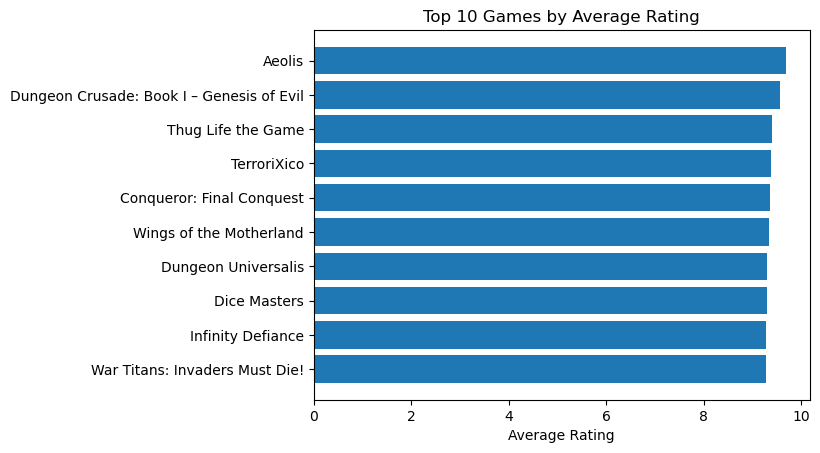

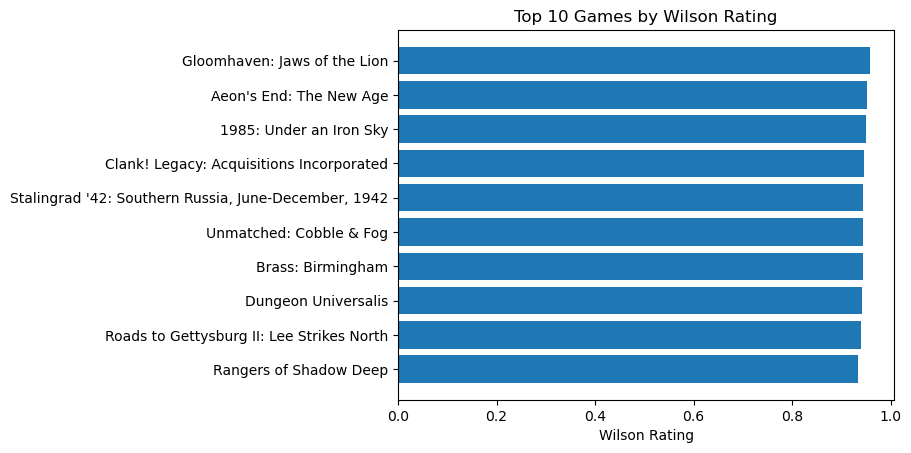

In [20]:
#visualizing the difference of the two rankings
#Get name of top10 based on avergae
namesA = [game[1] for game in top_10_average]
average_ranks = [game[2] for game in top_10_average]
#Get name of top10 based on wilson
namesW = [game[1] for game in top_10_wilson]
wilson_ranks = [game[2] for game in top_10_wilson]

import matplotlib.pyplot as plt

# Create a horizontal bar chart for average R
plt.figure()
plt.barh(namesA, average_ranks)
plt.xlabel('Average Rating')
plt.title('Top 10 Games by Average Rating')
plt.gca().invert_yaxis()  
plt.show()

plt.figure()
plt.barh(namesW, wilson_ranks)
plt.xlabel('Wilson Rating')
plt.title('Top 10 Games by Wilson Rating')
plt.gca().invert_yaxis() 
plt.show()

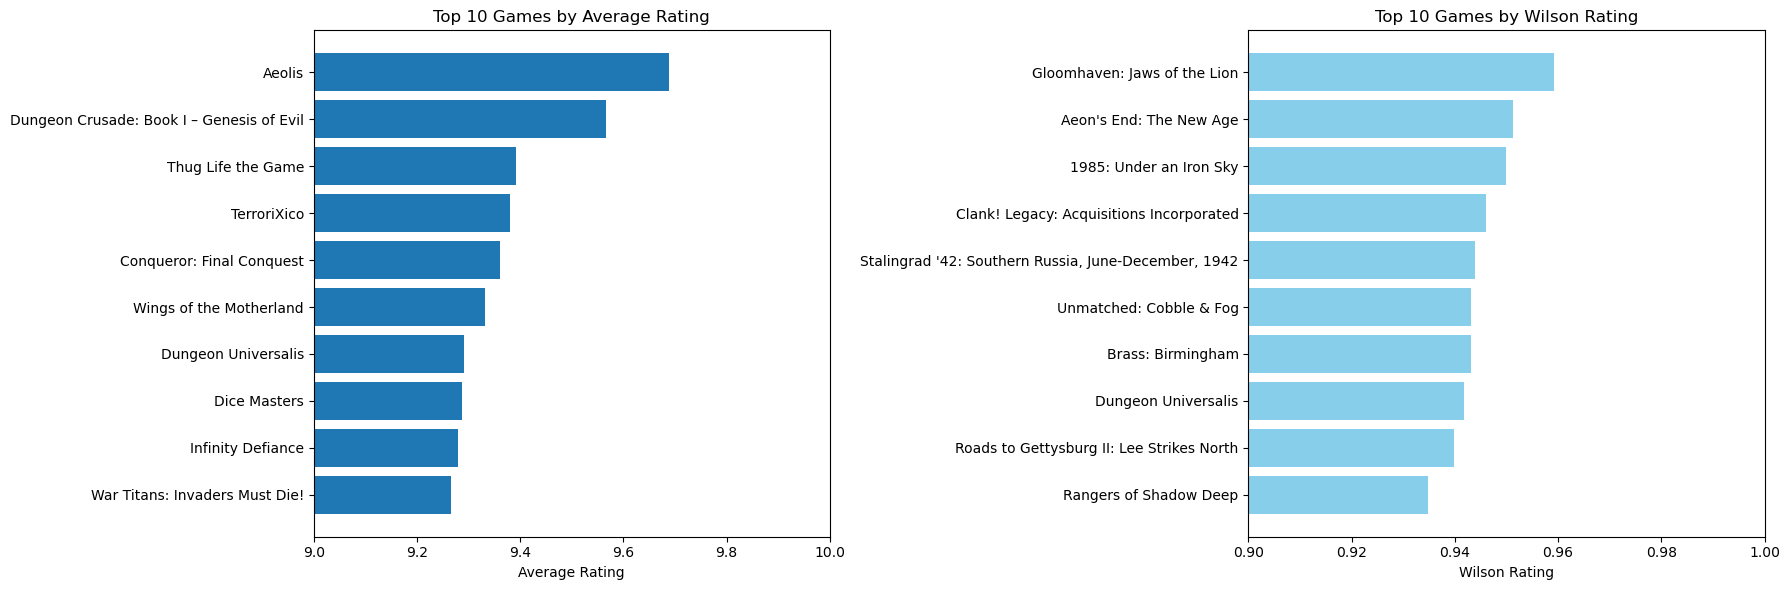

In [21]:
#Put them next to each other/ Subplots

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for average ratings
axes[0].barh(namesA, average_ranks)
axes[0].set_xlabel('Average Rating')
axes[0].set_title('Top 10 Games by Average Rating')
axes[0].invert_yaxis()
axes[0].set_xlim(9, 10)

# Plot for Wilson ranks
axes[1].barh(namesW, wilson_ranks, color='skyblue')
axes[1].set_xlabel('Wilson Rating')
axes[1].set_title('Top 10 Games by Wilson Rating')
axes[1].invert_yaxis()
axes[1].set_xlim(0.9, 1)


plt.tight_layout()
plt.show()